In [ ]:
import pandas as pd
import numpy as np
import datetime
import asyncpraw
import os
import time

In [ ]:
# source for `wallstreetbets_post.csv`: https://www.kaggle.com/mattpodolak/rwallstreetbets-posts-and-comments
# downloaded Feb 8, 2021
cols_of_interest = ['created_utc', 'id', 'score', 'num_comments']
full = pd.read_csv(f'wallstreetbets_posts.csv')[cols_of_interest]
# get January only
jan1 = datetime.datetime(year=2021, month=1, day=1)
feb1 = datetime.datetime(year=2021, month=2, day=1)
full['dt'] = full.created_utc.apply(datetime.datetime.fromtimestamp)
jan = full[(full.dt >= jan1) & (full.dt < feb1)]
# free memory
del full

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4,81,82,83,84) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
sample = pd.read_csv('data/start=2021-01-01_00:00:00_end=2021-02-01_00:00:00_n=446_seed=0/submissions_with_praw.csv')[['created_utc', 'id', 'score', 'num_comments', 'subreddit']]
sample['dt'] = sample.created_utc.apply(datetime.datetime.fromtimestamp)

In [ ]:
wsb = sample[sample.subreddit == 'wallstreetbets']

In [ ]:
len(jan), len(wsb)*100

(494490, 535000)

Looks like the post count is not too far off, although
the actual value is outside the amount suggested by 95% proportion confidence interval.

*Note that post deletion may have played a role here, re-running the sample could verify this.*

In [ ]:
jan.loc[:, 'date'] = jan['dt'].dt.date
jan.loc[:, 'weekday'] = jan['dt'].dt.weekday
jan.loc[:, 'day'] = jan['dt'].dt.day

wsb['date'] = wsb['dt'].dt.date
wsb['weekday'] = wsb['dt'].dt.weekday
wsb['day'] = wsb['dt'].dt.day

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

<AxesSubplot:>

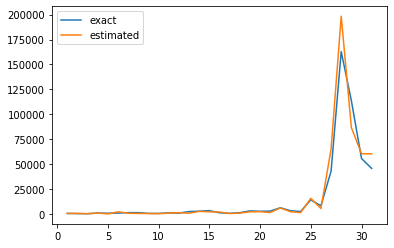

In [ ]:
submissions_per_day = jan.day.value_counts().sort_index().rename(index='exact')
est_submissions_per_day = wsb.day.value_counts().sort_index().rename(index='estimated') * 100

comparison = pd.concat(
    [submissions_per_day, est_submissions_per_day], axis=1
)
comparison.plot()


Estimated "fraction per day" minus exact "fraction per day"

Positive means the sample overstimates
Negative means the sample underestimates

<AxesSubplot:>

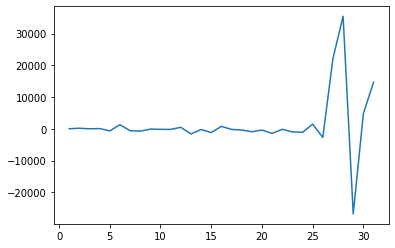

In [ ]:
comparison.diff(axis=1)['estimated'].plot()

So our estimates have some large errors on the days in which activity skyrocketed.
But in terms of percent change (below), this isn't actually so bad!

<AxesSubplot:>

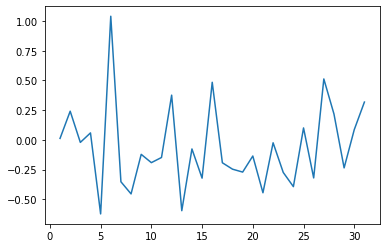

In [ ]:
comparison.pct_change(axis=1)['estimated'].plot()

# `score` and `num_comments`

Below, we compare descriptive stats for num_comments (pushshift). For pushshift scores (i.e. "initial" score)
the estimate is pretty close. For comments, however, our estimate is quite off!

While this may be related to comment deletion (verifiable by recollecting data), it's likely also
just related to the extreme skew of the `num_comments` variable. 

In [ ]:
cols = ['score' , 'num_comments']
pd.concat(
    [jan[cols].describe(), wsb[cols].describe()], axis=1
)

,score,num_comments,score,num_comments
count,494491.000000,494491.000000,5350.000000,5350.000000
mean,7.121495,14.532105,5.210280,3.599252
std,387.936323,744.362477,162.751611,32.111383
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000
max,83793.000000,150791.000000,11251.000000,1575.000000


In [ ]:
cols = ['score' , 'num_comments']
pd.concat(
    [jan[cols].skew(), wsb[cols].skew()], axis=1
)

,0,1
score,117.855592,63.347673
num_comments,113.677287,28.304375


Take a look at histogram of logged `num_comments`

<AxesSubplot:>

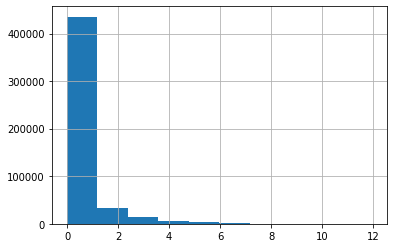

In [ ]:
import numpy as np
jan.num_comments.apply(np.log1p).hist()

To compare PRAW scores quickly,
we'll take an actual random sample from the full data
and hit PRAW scores. Otherwise, we run into the same problem we wanted
to solve all along (avoiding make API calls for every single post).

For a quick comparison, we'll do 1 random draw of 5% of submissions, and calculate the mean `praw_score`.

In [ ]:
# init PRAW reddit object. Used to grab most up-to-date post scores.
reddit = asyncpraw.Reddit(
     client_id=os.environ['CLIENT_ID'],
     client_secret=os.environ['CLIENT_SECRET'],
     user_agent=os.environ['USER_AGENT']
 )

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
samps = {}
for random_state in [0]:
    times = []
    praw_scores = {}
    praw_num_comments = {}
    num_chunks = 0
    samp = jan.sample(frac=0.1, random_state=random_state)
    print('length of sample', len(samp))
    for chunk in chunks(samp.id, 100):
        t1 = time.time()
        num_chunks += 1
        if num_chunks % 50 == 0:
            print('starting a chunk', len(chunk), len(praw_scores))
        list_of_ids = []
        for submission_id in chunk:
            list_of_ids.append("t3_{}".format(submission_id))
        
        if list_of_ids:
            reddit_submissions = reddit.info(fullnames=list_of_ids)
            time.sleep(1)
            async for submission in reddit_submissions:
                praw_scores[submission.id] = submission.score
                praw_num_comments[submission.id] = submission.num_comments
        tic = time.time() - t1
        times.append(tic)
    samp['praw_score'] = samp.id.map(praw_scores)
    samp['praw_num_comments'] = samp.id.map(praw_num_comments)
    samps[random_state] = samp
    print(samp.praw_score.mean(), samp.praw_num_comments.mean())
    #submissions.to_csv('wallstreetbets_posts_mod.csv')

length of sample 49449
starting a chunk 100 4900
starting a chunk 100 9900
starting a chunk 100 14897
starting a chunk 100 19896
starting a chunk 100 24892
starting a chunk 100 29889
starting a chunk 100 34880
starting a chunk 100 39877
starting a chunk 100 44875
79.66514995247628 9.71317923517159


In [ ]:
df = samps[0]

<AxesSubplot:xlabel='day'>

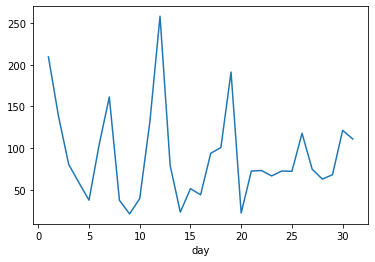

In [ ]:
df.groupby('day').praw_score.mean().plot()

## Random draws and the `num_comments` variable

Simulate random 1% draws from the full dataset to see if our
underestimate of `num_comments` is plausible.

In [ ]:
means = []
for random_state in range(0, 100):
    means.append(jan.sample(frac=0.01, random_state=random_state).num_comments.mean())
print(pd.Series(means).describe())

count    100.000000
mean      14.439100
std       11.218245
min        3.381800
25%        6.883771
50%       10.534580
75%       17.432963
max       62.274621
dtype: float64


<AxesSubplot:>

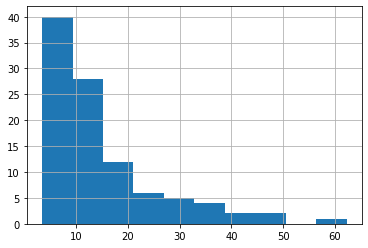

In [ ]:
pd.Series(means).hist()

Above results suggest our actual estimate (3.3) is at the very bottom end
of what we expect taking a straight random sample from full data.

In [ ]:
import random
# generate time windows to sample from

def generate_windows(
    start, end, window_size
):
    """
    start -  datetime object, the first timestamp
    end - datetime object, the last timestamp
    window_size - timedelta object, how long is each window (i.e. "cluster")?

    ret - a list of 2-tuples. Each tuples has 2 datetime objects. each is the start of a window.
    """
    ret = [(start, start+window_size)]
    while start < end:
        start += window_size
        ret.append((start, start+window_size))
    return ret

start_dt = datetime.datetime(2021, 1, 1)
end_dt = datetime.datetime(2021, 2, 1)

n = 0.01






# chosen_windows_as_timestamps = [
#     (int(x[0].timestamp()), int(x[1].timestamp())) 
#     for x in chosen_windows
# ]

In [ ]:
n

0.01

In [ ]:
import numpy as np


In [ ]:
rows = []


for window_sec in [
    5, 15, 30, 60, 120, 240, 480, 960
]:
    window_size = datetime.timedelta(seconds=window_sec)
    windows = generate_windows(start_dt, end_dt, window_size)
    means = []
    counts = []
    for seed in range(0,50):
        print(seed)
        random.seed(seed)
        if n < 1:
            n_as_int = int(len(windows) * n)
            print('len windows, n', len(windows), n_as_int)
            chosen_windows = random.sample(windows, n_as_int)
        else:
            chosen_windows = random.sample(windows, n)
        num_comments = np.array([])
        for i_window, window in enumerate(chosen_windows):
            # if i_window % 200 == 0:
            #     print(i_window, window, len(chosen_windows))
            subset = jan[
                (jan.dt > window[0]) &
                (jan.dt < window[1])
            ]
            num_comments = np.append(num_comments, subset.num_comments)
        means.append(np.mean(num_comments))
        counts.append(len(num_comments) / n)
    rows.append({
        'window_sec': window_sec,
        'means_mean': np.mean(means),
        'means_std': np.std(means),
        'counts_mean': np.mean(counts),
        'counts_std': np.std(counts),
    })

0
len windows, n 535681 5356
1
len windows, n 535681 5356
2
len windows, n 535681 5356
3
len windows, n 535681 5356
4
len windows, n 535681 5356
5
len windows, n 535681 5356
6
len windows, n 535681 5356
7
len windows, n 535681 5356
8
len windows, n 535681 5356
9
len windows, n 535681 5356
10
len windows, n 535681 5356
11
len windows, n 535681 5356
12
len windows, n 535681 5356
13
len windows, n 535681 5356
14
len windows, n 535681 5356
15
len windows, n 535681 5356
16
len windows, n 535681 5356
17
len windows, n 535681 5356
18
len windows, n 535681 5356
19
len windows, n 535681 5356
20
len windows, n 535681 5356
21
len windows, n 535681 5356
22
len windows, n 535681 5356
23
len windows, n 535681 5356
24
len windows, n 535681 5356
25
len windows, n 535681 5356
26
len windows, n 535681 5356
27
len windows, n 535681 5356
28
len windows, n 535681 5356
29
len windows, n 535681 5356
30
len windows, n 535681 5356
31
len windows, n 535681 5356
32
len windows, n 535681 5356
33
len windows, n 53

In [ ]:
results = pd.DataFrame(rows)

In [ ]:
means2 = []
for seed in range(0,10000):
    means2.append(jan.sample(frac=0.01, random_state=seed).num_comments.mean())


(10.900606673407482, 10.71731137715068)

In [ ]:
print(np.mean(means2), np.std(means2), np.median(means2), len(means2))
pd.Series(means2).hist()

(14.67537079878665, 10.71731137715068, 10.900606673407482)

10000

In [ ]:
len(jan)

494490

14.712434193496199 4.801576522912522 14.125323572237502 1000


<AxesSubplot:>

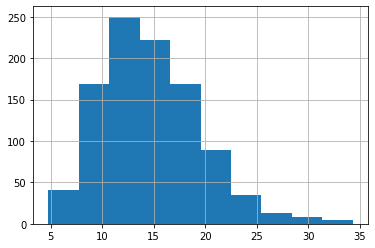

In [ ]:
means3 = []
for seed in range(0,1000):
    means3.append(jan.sample(frac=0.05, random_state=seed).num_comments.mean())

print(np.mean(means3), np.std(means3), np.median(means3), len(means3))
pd.Series(means3).hist()

In [ ]:
np.mean(means2)

14.879388270980787

In [ ]:
len(jan), jan.num_comments.mean(), jan.num_comments.sem()

(494490, 14.53213411798014, 1.058537272944212)

In [ ]:
results

,window_sec,means_mean,means_std,counts_mean,counts_std
0,5,12.324511,8.613632,398032.0,14448.826111
1,15,12.564696,9.879383,462342.0,28577.845195
2,30,16.780632,12.102876,477062.0,42467.860271
3,60,17.930784,12.892362,485938.0,65166.527881
4,120,16.380830,12.983084,491392.0,92973.550734
5,240,14.815816,9.923840,491456.0,121779.435308
6,480,14.237230,10.256619,491510.0,178925.208118
7,960,16.080160,13.380249,480776.0,259472.156163


In [ ]:
np.mean(means), np.std(means)

(10.659215999788021, 8.2335138588563)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d8dd8e7-abf2-4721-84cd-03779d208ef5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>